In [16]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image_dataset_from_directory
import cv2

In [65]:
#specifying the sizes and important parameters 
batch_size=32
channel=3
epochs=10

In [18]:
#loading the datasets from the directory
image_size = 165
batch_size = 32

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "training",
    shuffle=True,
    image_size=(image_size,image_size),
    batch_size=batch_size)

Found 1840 files belonging to 2 classes.


In [19]:
#checking the 2 classes in training dataset
class_names=dataset.class_names
class_names

['00-damage', '01-whole']

In [20]:
len(dataset) # as each batch is of size 32 (58*32=1840)

58

In [22]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 160, 160, 3)
[1 0 1 0 0 0 1 1 1 1 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 0 0 1]


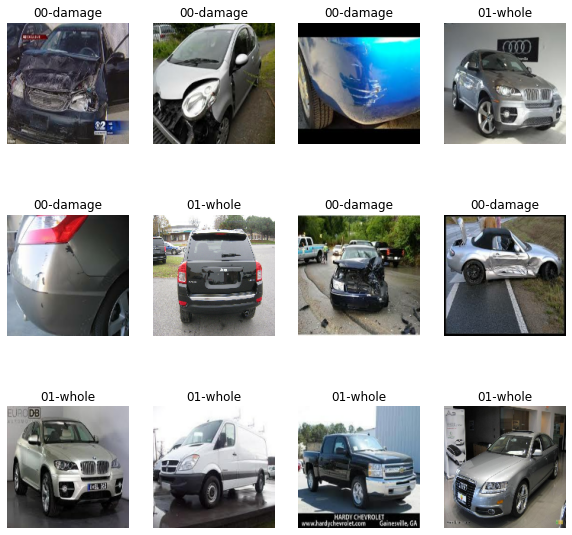

In [23]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [25]:
#forming the function to manually split train_test_dataset andvalidation split 
def train_test_splitting(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [26]:
train_data, val_data, test_data = train_test_splitting(dataset)

In [27]:
len(train_data)

46

In [28]:
len(test_data)

7

In [29]:
#Cache, Shuffle, and Prefetch the Dataset for improving the performance 
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [31]:
#resizing the datasets 
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(image_size,image_size),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [32]:
#Data Augmentation is needed when we have less data, 
#this increases the accuracy of our model.


data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


In [33]:
#applying augmentation to the train data
train_data = train_data.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [47]:
# creating the model
input_shape = (batch_size,image_size,image_size,channel)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3) , activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [48]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (32, 158, 158, 32)        896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (32, 79, 79, 32)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (32, 77, 77, 64)          18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (32, 38, 38, 64)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (32, 36, 36, 64)         

In [49]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [50]:
history = model.fit(
    train_data,
    batch_size=batch_size,
    validation_data=val_data,
    verbose=1,
    epochs=10,
)

Epoch 1/10
46/46 [==============================] - 31s 640ms/step - loss: 0.7049 - accuracy: 0.5296 - val_loss: 0.6787 - val_accuracy: 0.6250
Epoch 2/10
46/46 [==============================] - 33s 705ms/step - loss: 0.6727 - accuracy: 0.6006 - val_loss: 0.7478 - val_accuracy: 0.4938
Epoch 3/10
46/46 [==============================] - 33s 712ms/step - loss: 0.6621 - accuracy: 0.6398 - val_loss: 0.6841 - val_accuracy: 0.6187
Epoch 4/10
46/46 [==============================] - 33s 716ms/step - loss: 0.6483 - accuracy: 0.6271 - val_loss: 0.6173 - val_accuracy: 0.6750
Epoch 5/10
46/46 [==============================] - 32s 699ms/step - loss: 0.6569 - accuracy: 0.6129 - val_loss: 0.8731 - val_accuracy: 0.5437
Epoch 6/10
46/46 [==============================] - 32s 695ms/step - loss: 0.6049 - accuracy: 0.6731 - val_loss: 0.8925 - val_accuracy: 0.5250
Epoch 7/10
46/46 [==============================] - 32s 701ms/step - loss: 0.5985 - accuracy: 0.6924 - val_loss: 1.0576 - val_accuracy: 0.5250

In [51]:
scores=model.evaluate(test_data)

7/7 [==============================] - 8s 148ms/step - loss: 1.0620 - accuracy: 0.5670


In [52]:
# loss and accuracy value's list
scores 

[1.0619672536849976, 0.5669642686843872]

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

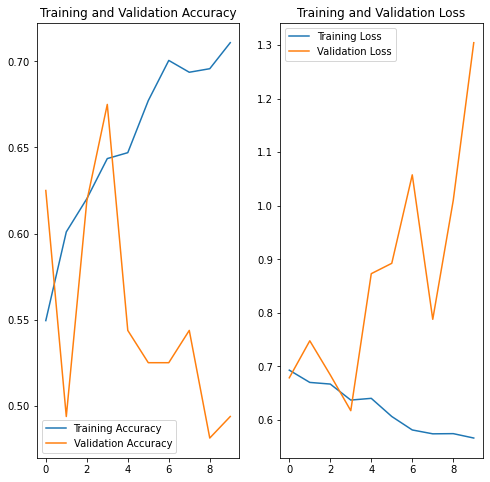

In [54]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: 01-whole
predicted label: 01-whole


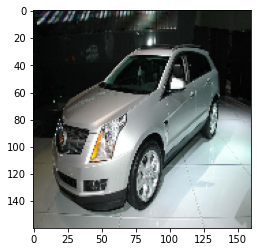

In [58]:
#testing over test_data
import numpy as np
for images_batch, labels_batch in test_data.take(1):
    
    first_image = images_batch[10].numpy().astype('uint8')
    first_label = labels_batch[10].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

first image to predict
actual label: 00-damage
predicted label: 01-whole


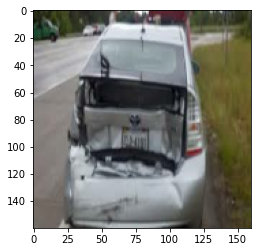

In [62]:
#an example where model could'nt guess it right
import numpy as np
for images_batch, labels_batch in test_data.take(1):
    
    first_image = images_batch[15].numpy().astype('uint8')
    first_label = labels_batch[15].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [66]:
print('Acquired accuracy', history.history['accuracy'][-2])

Acquired accuracy 0.6957417726516724
